<a href="https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.5: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and read our manuscript.
Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb), [v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/AlphaFold2.ipynb), [v1.5.3-patch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/56c72044c7d51a311ca99b953a71e552fdc042e1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

In [ ]:
import widgets

Text(value='PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK', description='query_sequence:', place…

Text(value='test', description='jobname:', placeholder='Insert job name')

Dropdown(description='num_relax:', options=(0, 1, 5), value=0)

Dropdown(description='template_mode:', options=('none', 'pdb100', 'custom'), value='none')

Dropdown(description='msa_mode:', options=('mmseqs2_uniref_env', 'mmseqs2_uniref', 'single_sequence', 'custom'…

Dropdown(description='pair_mode:', options=('unpaired_paired', 'paired', 'unpaired'), value='unpaired_paired')

Dropdown(description='model_type:', options=('auto', 'alphafold2_ptm', 'alphafold2_multimer_v1', 'alphafold2_m…

Dropdown(description='num_recycles:', index=3, options=('auto', '0', '1', '3', '6', '12', '24', '48'), value='…

Dropdown(description='recycle_early_stop_tolerance:', options=('auto', '0', '1', '3', '6', '12', '24', '48'), …

Dropdown(description='relax_max_iterations:', index=1, options=('0', '200', '2000'), value='200')

Dropdown(description='pairing_strategy:', options=('greedy', 'complete'), value='greedy')

Dropdown(description='max_msa:', options=('auto', '512:1024', '256:512', '64:128', '32:64', '16:32'), value='a…

Dropdown(description='num_seeds:', options=(1, 2, 4, 8, 16), value=1)

Label(value='testing')

Checkbox(value=False, description='use_dropout:')

Checkbox(value=False, description='save_all:')

Checkbox(value=False, description='save_recycles:')

IntText(value=200, description='dpi:')

Checkbox(value=True, description='display_images:')

Dropdown(description='rank_num:', options=(1, 2, 3, 4, 5), value=1)

Dropdown(description='color:', index=1, options=('chain', 'lDDT', 'rainbow'), value='lDDT')

Checkbox(value=False, description='show_sidechains:')

Checkbox(value=False, description='show_mainchains:')

In [ ]:
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = query_sequence_w.value 
jobname = jobname_w.value
num_relax = num_relax_w.value
template_mode = template_mode_w.value

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None # change this?
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))



jobname test_a5e17_94
sequence PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK
length 59


In [ ]:
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

# if not os.path.isfile("COLABFOLD_READY"):
#   print("installing colabfold...")
#   os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
#   # if os.environ.get('TPU_NAME', False) != False:
#   os.system("pip uninstall -y jax jaxlib")
#   os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12]' -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
#   os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
#   os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
#   os.system("touch COLABFOLD_READY")

# if USE_AMBER or USE_TEMPLATES:
#   if not os.path.isfile("CONDA_READY"):
#     print("installing conda...")
#     os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
#     os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
#     os.system("mamba config --set auto_update_conda false")
#     os.system("touch CONDA_READY")

# if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
#   print("installing hhsuite and amber...")
#   os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
#   os.system("touch HH_READY")
#   os.system("touch AMBER_READY")
# else:
#   if USE_TEMPLATES and not os.path.isfile("HH_READY"):
#     print("installing hhsuite...")
#     os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
#     os.system("touch HH_READY")
#   if USE_AMBER and not os.path.isfile("AMBER_READY"):
#     print("installing amber...")
#     os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
#     os.system("touch AMBER_READY")

CPU times: user 4 μs, sys: 1 μs, total: 5 μs
Wall time: 8.34 μs


In [ ]:
# MSA options
msa_mode = msa_mode_w.value
pair_mode = pair_mode_w.value

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [ ]:
# Advanced settings
model_type = model_type_w.value
num_recycles = num_recycles_w.value
recycle_early_stop_tolerance = recycle_early_stop_tolerance_w.value
relax_max_iterations = relax_max_iterations_w.value
pairing_strategy = pairing_strategy_w.value

max_msa = max_msa_w.value
num_seeds = num_seeds_w.value
use_dropout = use_dropout_w.value

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

save_all = save_all_w.value
save_recycles = save_recycles_w.value
dpi = dpi_w.value


2024-08-13 15:04:02,826 Running on GPU
2024-08-13 15:04:02,846 Found 5 citations for tools or databases
2024-08-13 15:04:02,846 Query 1/1: test_a5e17_94 (length 59)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:02 remaining: 00:00]


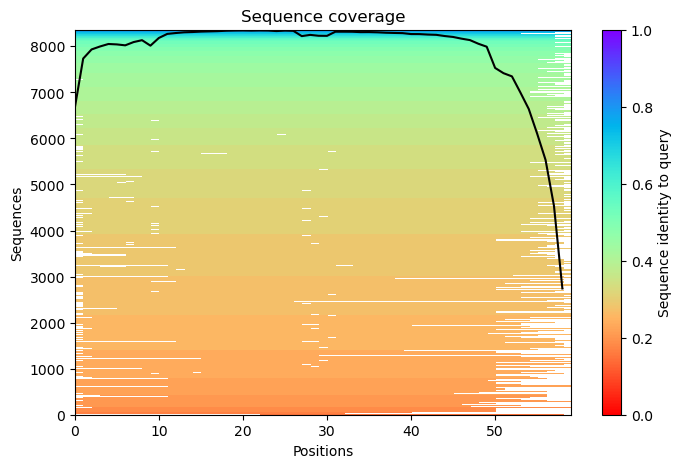

2024-08-13 15:04:05,758 Setting max_seq=512, max_extra_seq=5120
2024-08-13 15:04:29,911 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=96.6 pTM=0.754
2024-08-13 15:04:31,507 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=96.5 pTM=0.758 tol=0.305
2024-08-13 15:04:33,103 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=96.2 pTM=0.754 tol=0.0495
2024-08-13 15:04:34,701 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=96 pTM=0.755 tol=0.0455
2024-08-13 15:04:34,702 alphafold2_ptm_model_1_seed_000 took 23.1s (3 recycles)


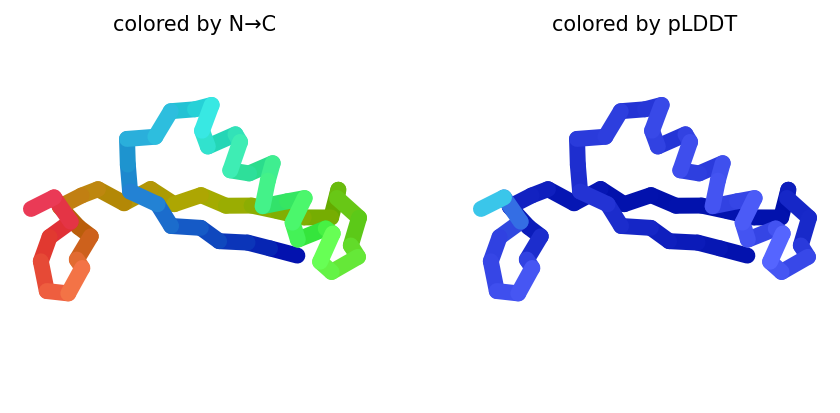

2024-08-13 15:04:36,448 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=96.9 pTM=0.759
2024-08-13 15:04:38,052 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=96.9 pTM=0.766 tol=0.348
2024-08-13 15:04:39,669 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=96.8 pTM=0.765 tol=0.113
2024-08-13 15:04:41,276 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=96.8 pTM=0.768 tol=0.0823
2024-08-13 15:04:41,277 alphafold2_ptm_model_2_seed_000 took 6.4s (3 recycles)


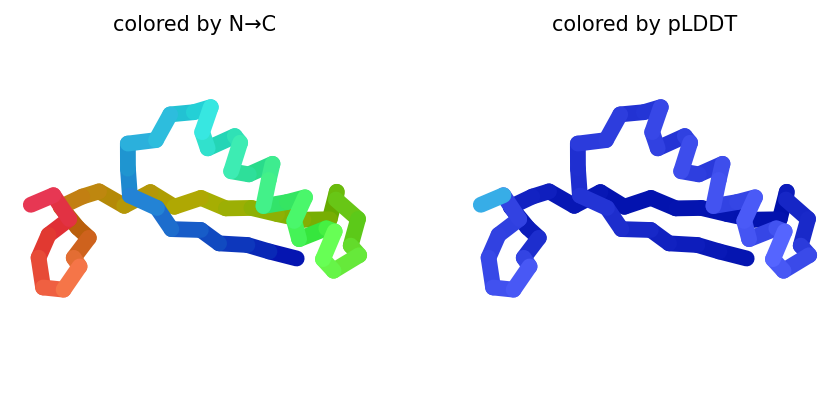

2024-08-13 15:04:42,972 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=97.2 pTM=0.774
2024-08-13 15:04:44,587 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=97.4 pTM=0.782 tol=0.32
2024-08-13 15:04:46,201 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=97.4 pTM=0.782 tol=0.129
2024-08-13 15:04:47,817 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=97.4 pTM=0.784 tol=0.038
2024-08-13 15:04:47,818 alphafold2_ptm_model_3_seed_000 took 6.5s (3 recycles)


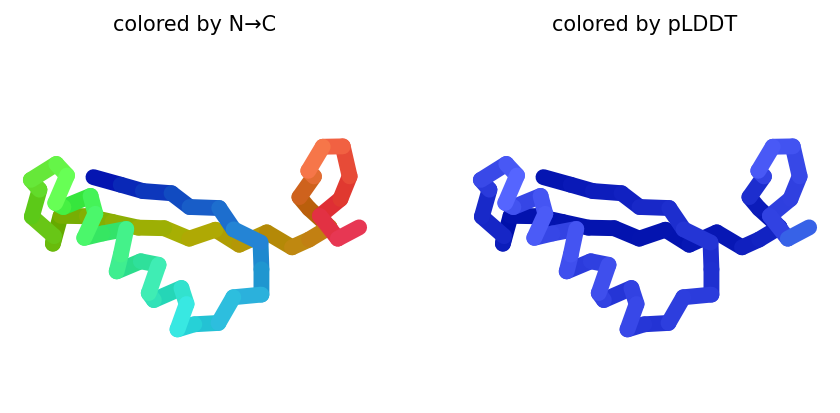

2024-08-13 15:04:49,523 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=97.4 pTM=0.774
2024-08-13 15:04:51,186 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=97.4 pTM=0.781 tol=0.319
2024-08-13 15:04:52,804 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=97.1 pTM=0.776 tol=0.0744
2024-08-13 15:04:54,424 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=96.9 pTM=0.777 tol=0.0474
2024-08-13 15:04:54,424 alphafold2_ptm_model_4_seed_000 took 6.5s (3 recycles)


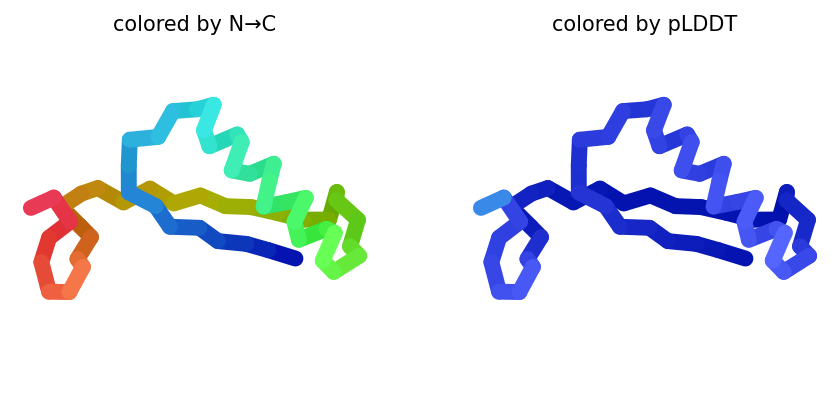

2024-08-13 15:04:56,130 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=97.4 pTM=0.783
2024-08-13 15:04:57,754 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=97.1 pTM=0.785 tol=0.259
2024-08-13 15:04:59,377 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=96.2 pTM=0.775 tol=0.173
2024-08-13 15:05:01,009 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=96.1 pTM=0.778 tol=0.129
2024-08-13 15:05:01,010 alphafold2_ptm_model_5_seed_000 took 6.5s (3 recycles)


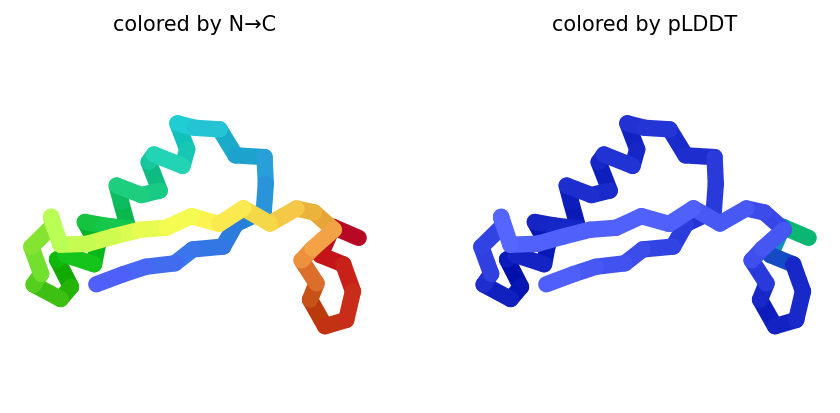

2024-08-13 15:05:01,158 reranking models by 'plddt' metric
2024-08-13 15:05:01,159 rank_001_alphafold2_ptm_model_3_seed_000 pLDDT=97.4 pTM=0.784
2024-08-13 15:05:01,169 rank_002_alphafold2_ptm_model_4_seed_000 pLDDT=96.9 pTM=0.777
2024-08-13 15:05:01,174 rank_003_alphafold2_ptm_model_2_seed_000 pLDDT=96.8 pTM=0.768
2024-08-13 15:05:01,181 rank_004_alphafold2_ptm_model_5_seed_000 pLDDT=96.1 pTM=0.778
2024-08-13 15:05:01,193 rank_005_alphafold2_ptm_model_1_seed_000 pLDDT=96 pTM=0.755
2024-08-13 15:05:02,117 Done


sh: 1: zip: not found


32512

In [ ]:
# Run Prediction
display_images = display_images_w.value
import os
os.environ['MPLCONFIGDIR'] = '~/.cache'
%matplotlib inline

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2


import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass

if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path



import matplotlib.pyplot as plt


# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

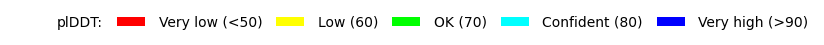

In [ ]:
# Display 3D structure
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = rank_num_w.value
color = color_w.value
show_sidechains = show_sidechains_w.value
show_mainchains = show_mainchains_w.value

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()


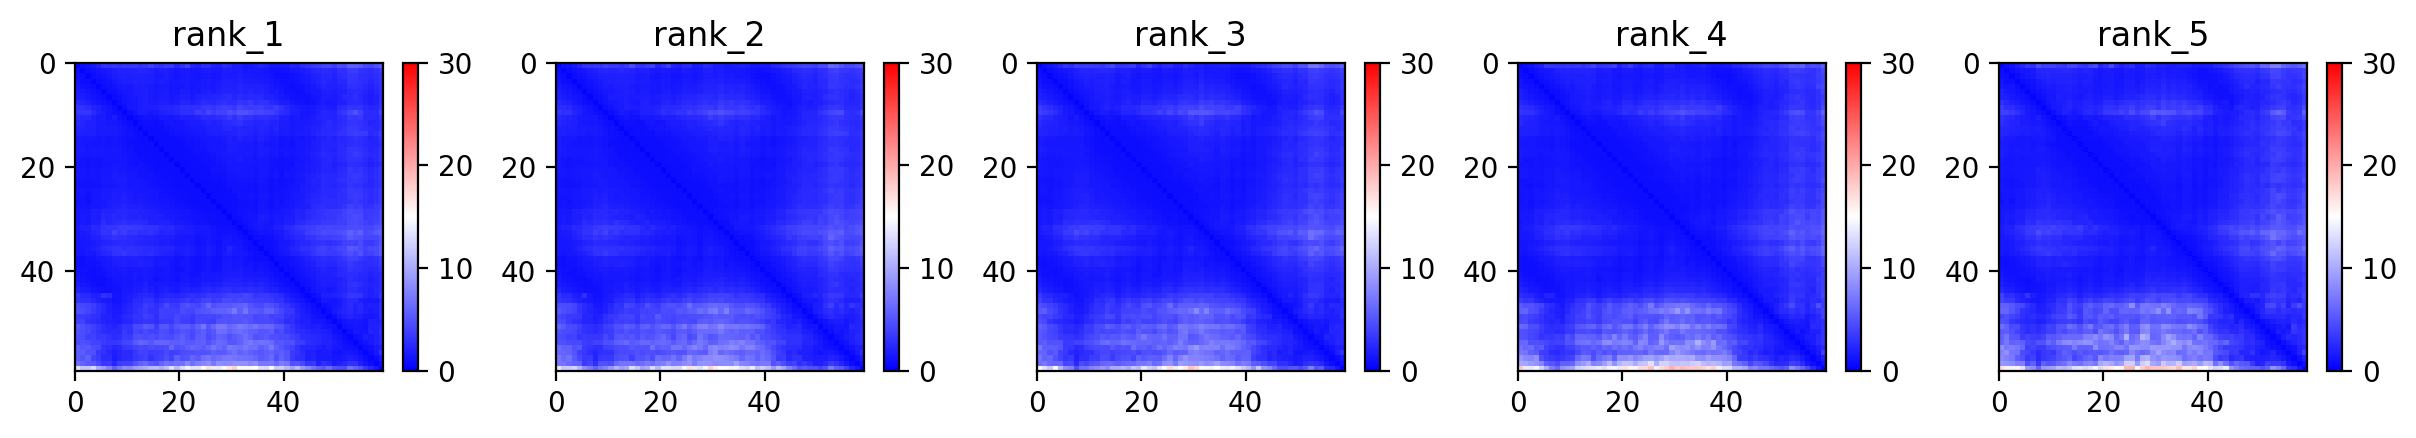
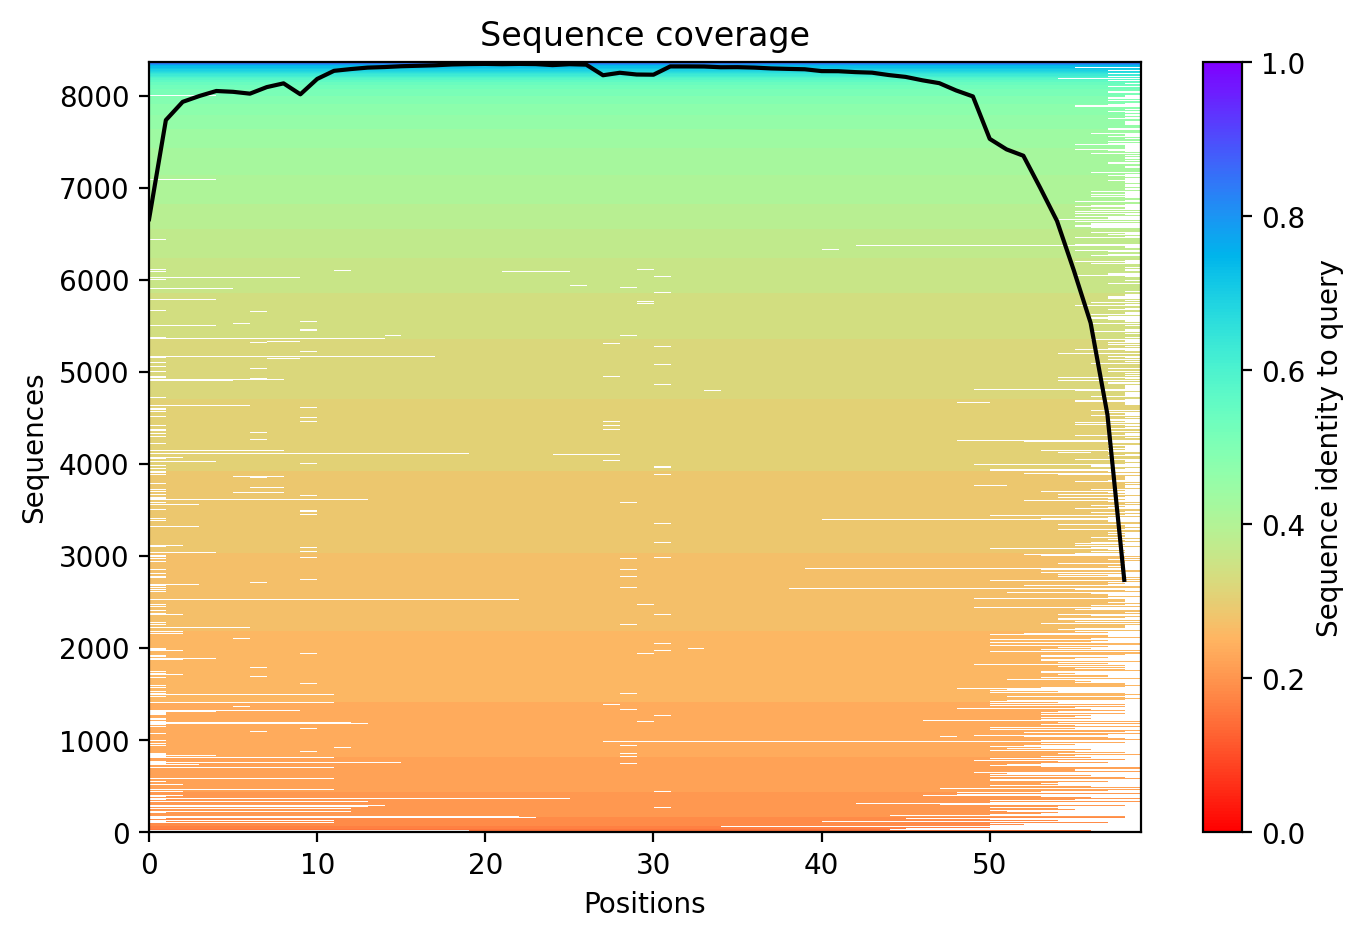
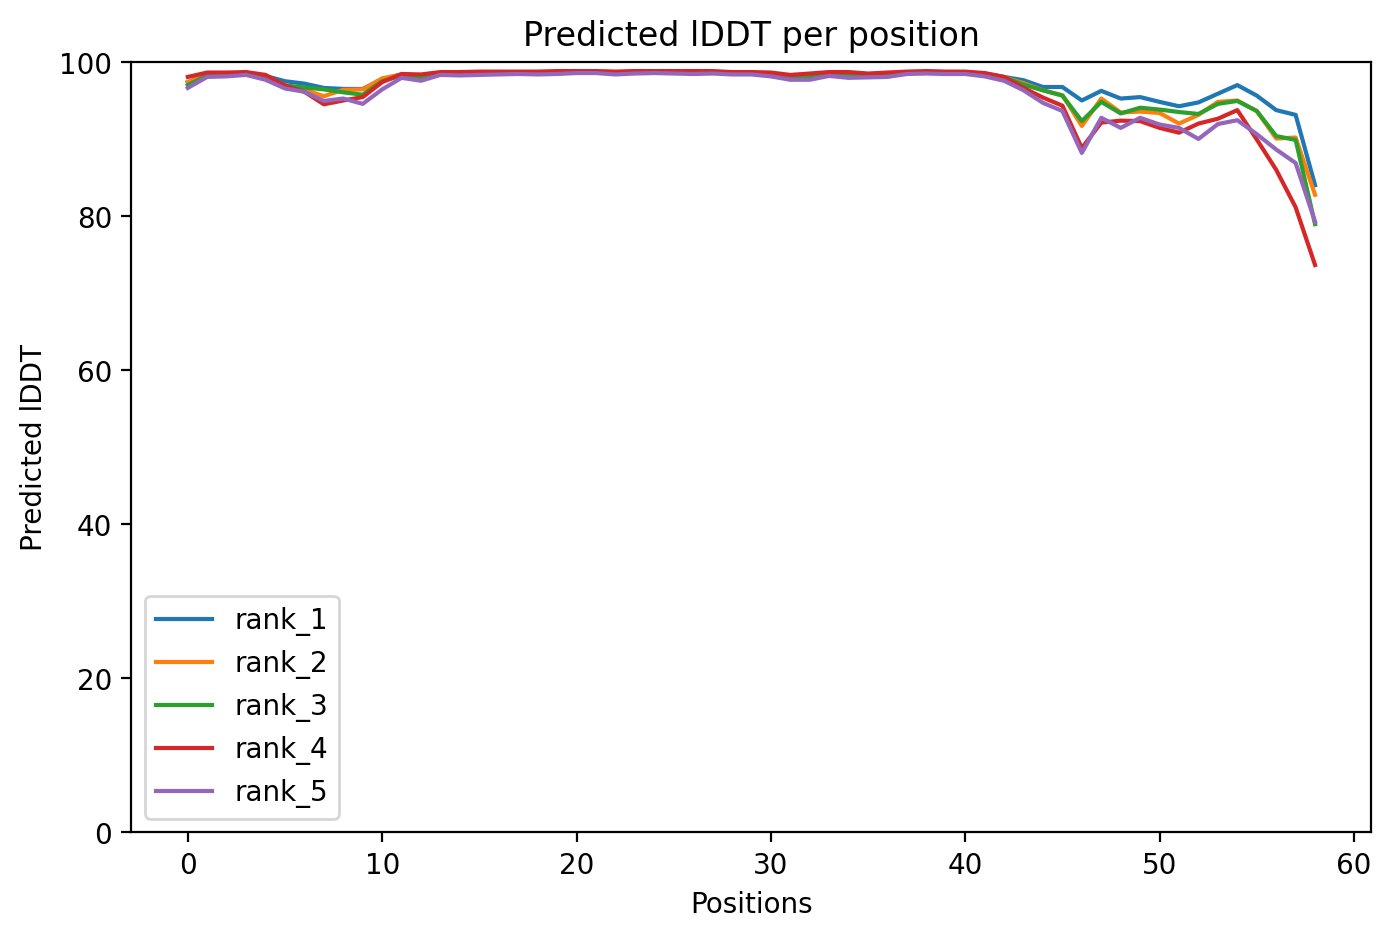

In [ ]:
## @title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))


# Instructions <a name="Instructions"></a>
**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomic identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomic identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the `msa_mode`: to "custom", (2) Wait for an upload box to appear at the end of the "MSA options ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

It is also possilbe to proide custom MSAs for complex predictions. Read more about the format [here](https://github.com/sokrypton/ColabFold/issues/76).

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**PDB100** <a name="pdb100"></a>

As of 23/06/08, we have transitioned from using the PDB70 to a 100% clustered PDB, the PDB100. The construction methodology of PDB100 differs from that of PDB70.

The PDB70 was constructed by running each PDB70 representative sequence through [HHblits](https://github.com/soedinglab/hh-suite) against the [Uniclust30](https://uniclust.mmseqs.com/). On the other hand, the PDB100 is built by searching each PDB100 representative structure with [Foldseek](https://github.com/steineggerlab/foldseek) against the [AlphaFold Database](https://alphafold.ebi.ac.uk).

To maintain compatibility with older Notebook versions and local installations, the generated files and API responses will continue to be named "PDB70", even though we're now using the PDB100.

**Using custom templates** <a name="custom_templates"></a>

To predict the structure with a custom template (PDB or mmCIF formatted): (1) change the `template_mode` to "custom" in the execute cell and (2) wait for an upload box to appear at the end of the "Input Protein" box. Select and upload your templates (multiple choices are possible).

* Templates must follow the four letter PDB naming with lower case letters.

* Templates in mmCIF format must contain `_entity_poly_seq`. An error is thrown if this field is not present. The field `_pdbx_audit_revision_history.revision_date` is automatically generated if it is not present.

* Templates in PDB format are automatically converted to the mmCIF format. `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date` are automatically generated.

If you encounter problems, please report them to this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**Comparison to the full AlphaFold2 and AlphaFold2 Colab**

This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparison against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [paper](https://www.nature.com/articles/s41592-022-01488-1).

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.

- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).
